In [1]:
import os
import ROOT
import numpy as np
import pandas as pd


from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from multihist import Hist1d, Histdd

import scipy.integrate as sp_int
from scipy.optimize import curve_fit
import scipy.stats as sps
%matplotlib inline

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['image.cmap'] = 'viridis'
#see the AP(copy) and save!!!!! the fit parameters (res)

In [15]:
path = "/home/cristian/Suxess_files/data/run6/liquid/ap180226/"
path_CSV="/home/cristian/Suxess_files/data/run6/"
#board=0
#channel=3
os.listdir(path)

['processed_wf5_Board0_AP_LED_2.40V.root',
 'processed_wf2_Board1_AP_LED_2.43V.root',
 'processed_wf5_Board1_AP_LED_2.40V.root',
 'processed_wf3_Board1_AP_LED_2.40V.root',
 'processed_wf2_Board0_AP_LED_2.43V.root',
 'processed_wf4_Board1_AP_LED_2.38V.root',
 'AP_figs',
 'processed_wf1_Board0_AP_LED_2.43V.root',
 'processed_wf3_Board0_AP_LED_2.37V.root',
 'processed_wf4_Board0_AP_LED_2.37V.root',
 'processed_wf1_Board1_AP_LED_2.43V.root',
 'processed_wf6_Board1_AP_LED_2.48V.root',
 'processed_wf0_Board0_AP_LED_2.35V.root',
 'processed_wf0_Board1_AP_LED_2.35V.root',
 'processed_wf6_Board0_AP_LED_2.45V.root']

In [16]:
elem_charge = 1.6021766e-19

def area_to_charge(a):
    # area in adc counts * 10 * ns
    factor = 2.25 * 10e-9 / (2**14 * 50) #  * elem_charge)
    return factor * (a / 10)

In [17]:
illum_pe = []

def process_ap_file(filename):
    file = ROOT.TFile(filename)
    tree = file.Get('T1')

    pos = []
    area = []
    #entropy = []
    height = []
    width50 = []
    evtnb =[]
    for event in tqdm(file.Get('T1')):
        if len(event.Position)>0:
            for p in event.Position:
                pos.append(p)
        if len(event.Area)>0:        
            for a in event.Area:
                area.append(a)
        #for e in event.Entropy:
          #  entropy.append(e)
        if len(event.Height)>0:
            for h in event.Height:
                height.append(h)
        if len(event.Width50)>0:
            for w in event.Width50:
                width50.append(w)
        #for ev in event.Evtnb:
            #evtnb.append(ev)not the same lenght of area, positio etc. It's only the total number of waveforms not number of peaks
    d = {'time': np.array(pos),
        'area': area_to_charge(np.array(area))/(5e6 * elem_charge),
        'height': np.array(height),
        'width50':np.array(width50)}#,
        #'event_number': np.array(evtnb)}
    df = pd.DataFrame(d)
    t0_df=df[df['area']>100]
    t0 = np.mean(t0_df.time)
    d={'time': np.array((pos-t0)/100),
       'area': area_to_charge(np.array(area))/(5e6 * elem_charge),
       'height': np.array(height),
       'width50': np.array(width50)}#,
       #'event_number': np.array(evtnb)}
    df = pd.DataFrame(d)
    
    #print (df[df['area']<0])
    #print(df[df['area']==0])
    return df

In [5]:
def estimateArPosition(V):
    R2 = 72.6e6 #resistence after photocatode
    R1 = 92.6e6 #Total resistence
    
    fV = V - (V*R2)/R1
    ArPeak = 29.4402*np.sqrt(1/fV)
    return ArPeak - 0.07

def estimateXePosition(V):
    R2 = 72.6e6 #resistence after photocatode
    R1 = 92.6e6 #Total resistence
    fV = V - (V*R2)/R1
    XePeak = 53.2778*np.sqrt(1/fV)
    return XePeak - 0.11



In [6]:
def plot_hw(data_frame, pmt):
    #data_frame = data_frame[(data_frame['area']>=0) & (data_frame['time']>-0.1)]
    plt.figure(figsize=(10,6))
    #data_frame1=data_frame[data_frame['entropy']<0.4]
    #print(data_frame)
    #data_frame1=data_frame[((data_frame['height']>300)|(data_frame['width50']<10))]
    plt.hist2d(data_frame['width50'], data_frame['height'], bins=(60,500), range=((0, 60), (0,500)), norm=LogNorm()) #bins 200
    plt.colorbar(label='counts')
    plt.xlabel('width (*10 ns)')
    plt.ylabel('height (ADC)')
    plt.title('PMT %d' % pmt)
    #plt.savefig(path+ 'AP_figs/' + 'ap_pmt%d_run2_gas.png' % pmt, dpi=150)
    plt.show()

In [7]:
def plot(data_frame, pmt, valHV5e6,day):
    #data_frame = data_frame[(data_frame['area']>=0) & (data_frame['time']>-0.1)]
    plt.figure(figsize=(10,6))
    #data_frame1=data_frame[((data_frame['height']<100)|(data_frame['width50']>4))]
    #print(data_frame)
    plt.hist2d(data_frame['time'], data_frame['area'], bins=(550,500), range=((-0.5, 5), (0,50)), norm=LogNorm()) #bins 200
    plt.colorbar(label='counts')
    XePeak = estimateXePosition(valHV5e6)
    ArPeak = estimateArPosition(valHV5e6)
    plt.axvline(ArPeak, color='b', linestyle='dashed', linewidth=2, label = 'expected Ar peak')
    plt.axvline(XePeak, color='red', linestyle='dashed', linewidth=2, label = 'expected Xe peak')
    plt.legend(loc = 'upper right')
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Area [pe]')
    plt.title('PMT %d' % pmt)
    plt.savefig(path+ 'AP_figs/' + 'ap_pmt%d_run6_%d.png' % (pmt,day), dpi=150, transparent= False)
    plt.show()

In [8]:
def to_pmt(board, channel):
    if board == 0:
        return channel + 1
    if board == 1 and channel==0:
        return 9
    if board ==1 and channel!=6:
        return channel+9
    if board ==1 and channel==6:
        return 8

In [9]:
arHV5e6 = [1402.7,1332.3,1332.7,1480.0,1434.2,1386.8,1407.6,1418.5,1357.4,1391.5,1395.3,1366.0,1356.4,1436.7]#run 6 liquid
#[1428.6,1352.8,1360.8,1487.1, 1443.2,1451.0,1422.4,1429.3,1378.7,1430.0,1432.7,1374.0,1365.0,1447.9] #run6 gas
#[1408.3,1406.4,1465.0,1449.3,1489.4,1391.1,1381.1,1427.1,1510.8,1450.7,1450.7,1409.1,1454.6,1447.5,0] #gas run 0
# liquid run 0:[1385.2,1392.6,1444.1,1449.7,1467.1,1423.5,1385.2,1433.5,1486.3,1436.9,1415.4,1426.1,1464.2,0]
#[1517.8,1377.6,1450.1,1521.4,1375.0,1416.9,0,1421.5,1356.3,1419.9,1357.5,1379.3,1356.6,1468.4]#gas run4
#gas run 5: [1445.6,1375.1,0,1450.2,1417.1,1352.9,1406.8,1406.2,1406.8,1402.4,1340.7,1344.5,1382.9,1402.0]
# liquid run 5: [1405.3,1365.4,1398.7,1397.4,1400,1344.1,1377.5,1373.5,1389.6,1374.5,1312.1,1340.2,1368.3,1382.9]
#[1429.7,1486.4,1456.8,1481.6,1490.7,1503.3,1399.0,1434.8,1432.6,1454.7,1469.1,1384.7,1453.5,1449.0] # insert the numerical values for the 5e6HV
arr=np.array(arHV5e6)

In [18]:
DF_all=[0]*14

for file in os.listdir(path):
    if 'counts' in file:
        continue
    if 'AP_figs' in file:
        continue
    print(file)
    channel = int(file.split("_")[1].lstrip("wf"))
    board = int(file.split("_")[2].lstrip("Board"))
    pmt = channel + 1 + board * 7
    run = int(path.split("/")[5].lstrip("run"))
    day = int(path.split("/")[7].lstrip("ap"))
    
    
    #pmt = to_pmt(board,channel)  #ONLY FOR RUN 0!!!
    #print(pmt)
    #if pmt == None:
    #    continue
        
        
    AP_data = process_ap_file(path + file)
    DF_all[pmt-1]=AP_data
    print(pmt-1)
    #plot_hw(AP_data,pmt)
    #plot(AP_data, pmt , arr[pmt-1])
    #plt.savefig('ap_pmt%d_run0_vacuum.png' % pmt, dpi=150)
    

1577it [00:00, 15763.02it/s]

processed_wf5_Board0_AP_LED_2.40V.root


250000it [00:10, 23942.02it/s]
1793it [00:00, 17923.31it/s]

5
processed_wf2_Board1_AP_LED_2.43V.root


250000it [00:10, 23065.78it/s]
1896it [00:00, 18952.70it/s]

9
processed_wf5_Board1_AP_LED_2.40V.root


250000it [00:10, 23433.39it/s]
1921it [00:00, 19206.13it/s]

12
processed_wf3_Board1_AP_LED_2.40V.root


250000it [00:11, 22328.47it/s]
1444it [00:00, 14435.75it/s]

10
processed_wf2_Board0_AP_LED_2.43V.root


250000it [00:11, 22517.87it/s]
1816it [00:00, 18149.46it/s]

2
processed_wf4_Board1_AP_LED_2.38V.root


250000it [00:10, 23621.37it/s]
1984it [00:00, 19836.85it/s]

11
processed_wf1_Board0_AP_LED_2.43V.root


250000it [00:11, 22230.89it/s]
1653it [00:00, 16525.84it/s]

1
processed_wf3_Board0_AP_LED_2.37V.root


250000it [00:10, 23583.01it/s]
1613it [00:00, 16123.94it/s]

3
processed_wf4_Board0_AP_LED_2.37V.root


250000it [00:10, 23792.23it/s]
1716it [00:00, 17153.80it/s]

4
processed_wf1_Board1_AP_LED_2.43V.root


250000it [00:10, 22807.01it/s]
1749it [00:00, 17486.76it/s]

8
processed_wf6_Board1_AP_LED_2.48V.root


250000it [00:11, 22624.85it/s]
1956it [00:00, 19554.52it/s]

13
processed_wf0_Board0_AP_LED_2.35V.root


250000it [00:10, 23592.44it/s]
2028it [00:00, 20268.28it/s]

0
processed_wf0_Board1_AP_LED_2.35V.root


250000it [00:10, 23766.09it/s]
1909it [00:00, 19080.87it/s]

7
processed_wf6_Board0_AP_LED_2.45V.root


250000it [00:10, 23018.16it/s]


6


0


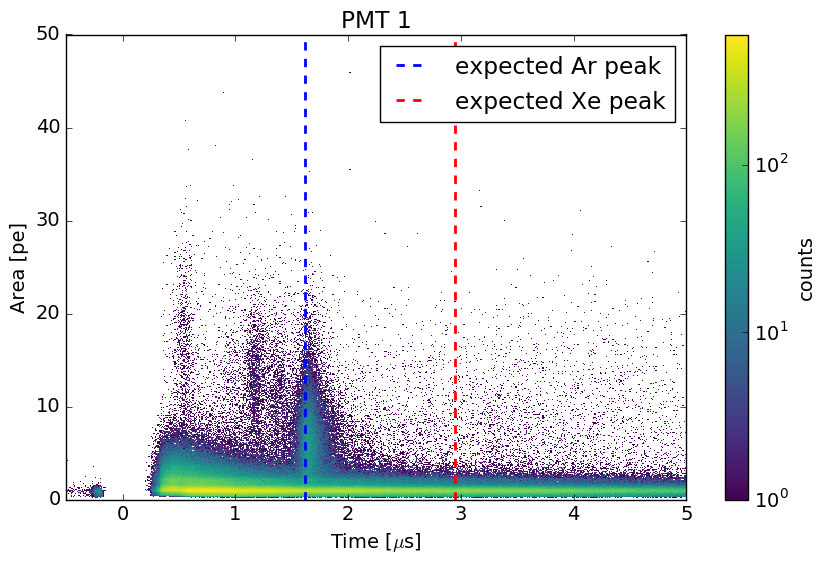

1


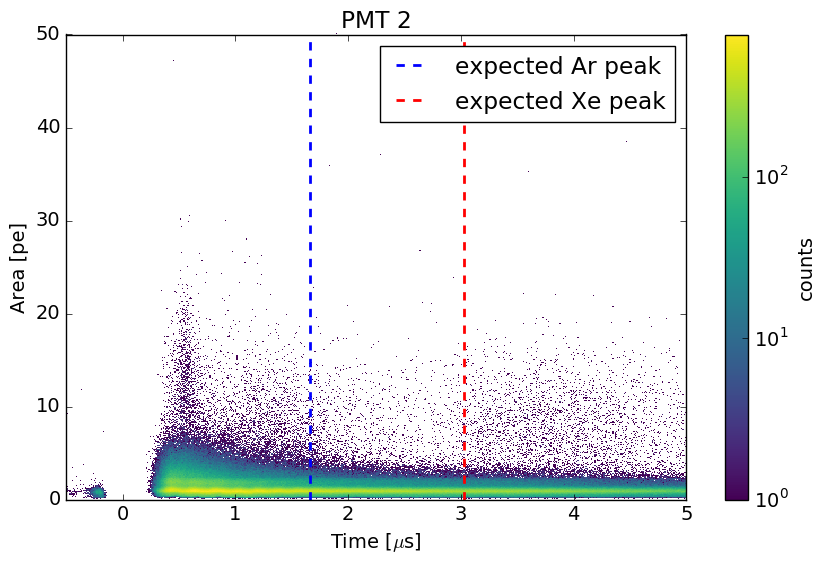

2


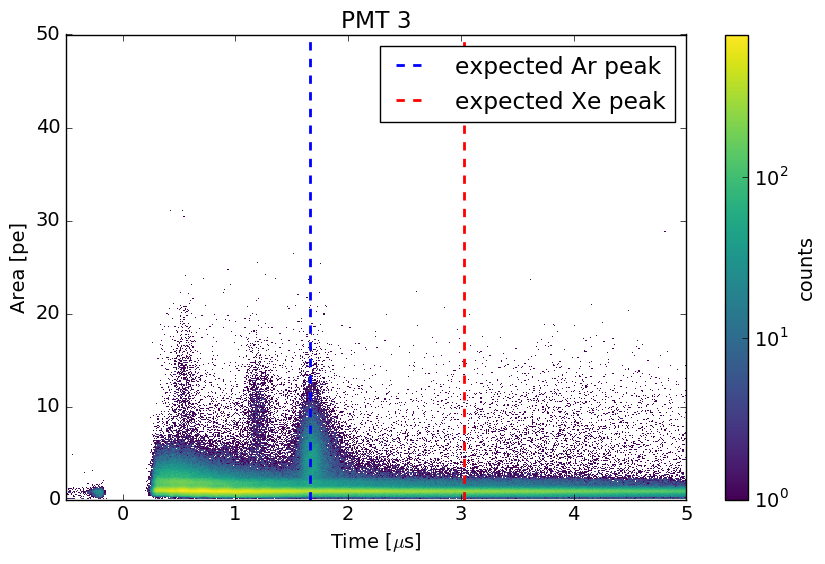

3


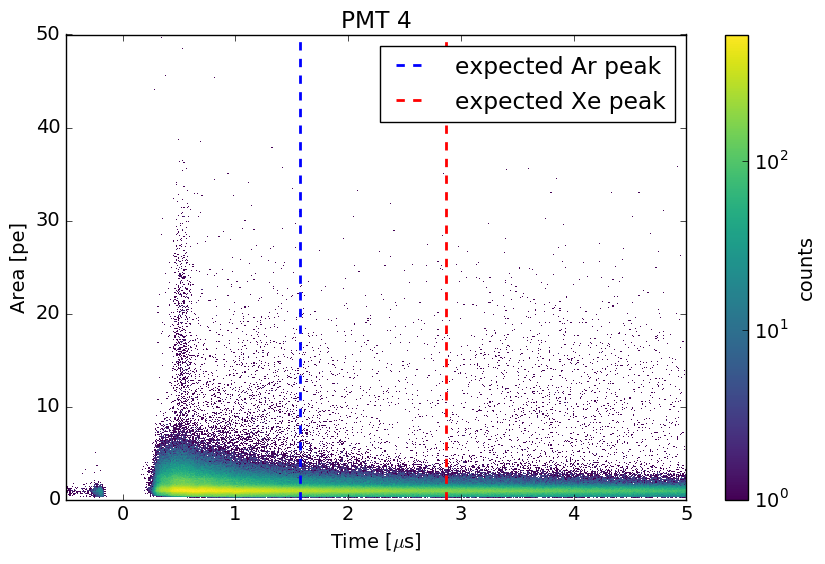

4


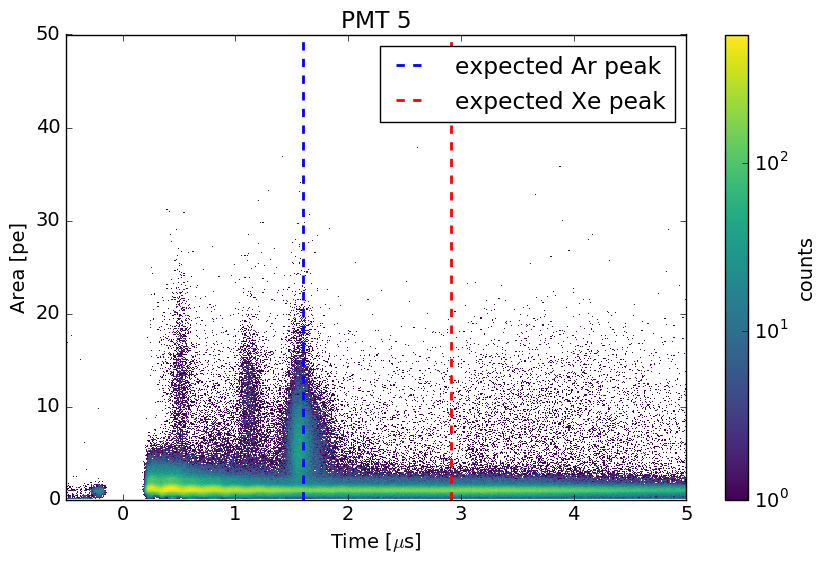

5


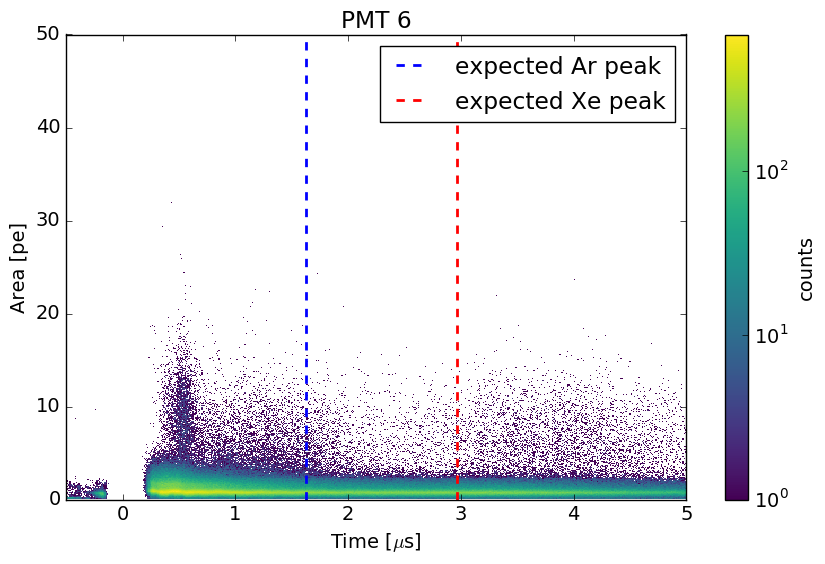

6


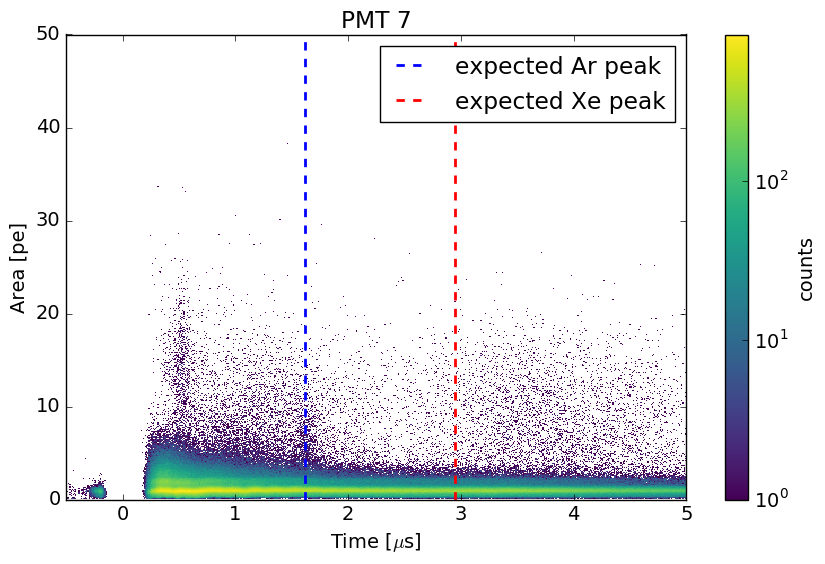

7


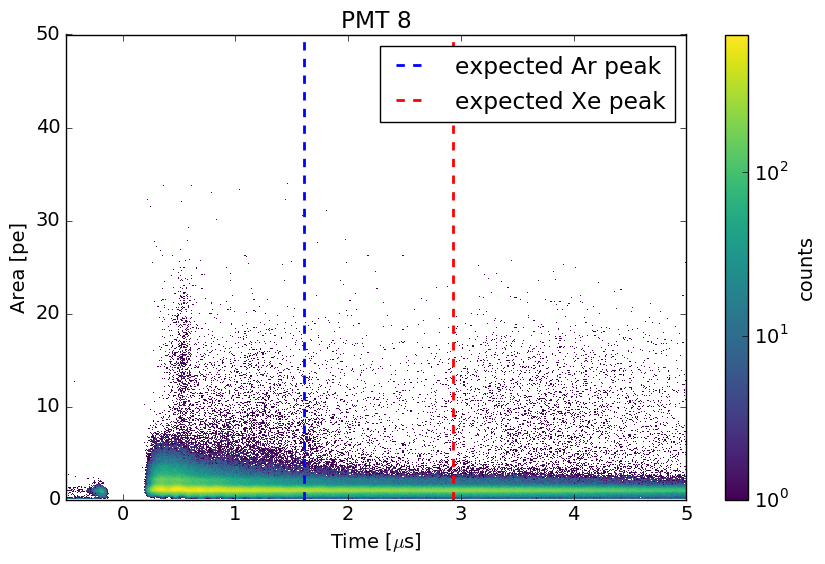

8


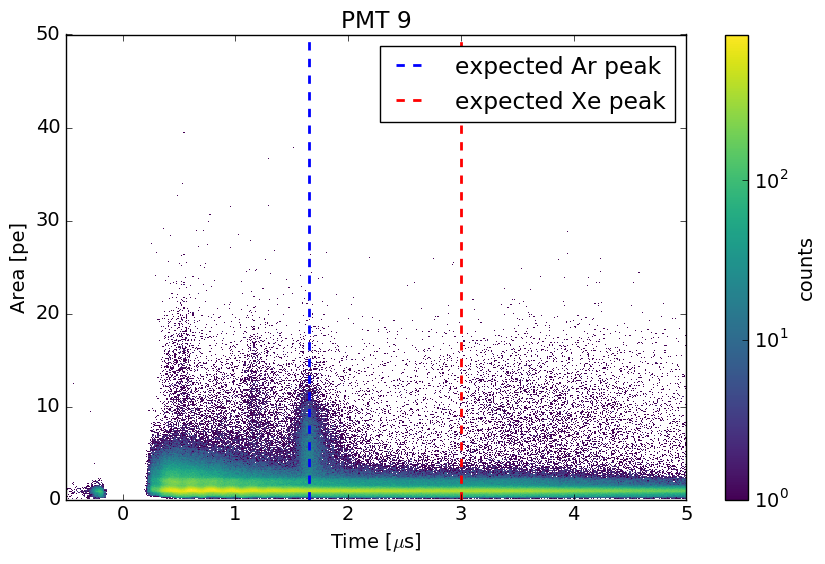

9


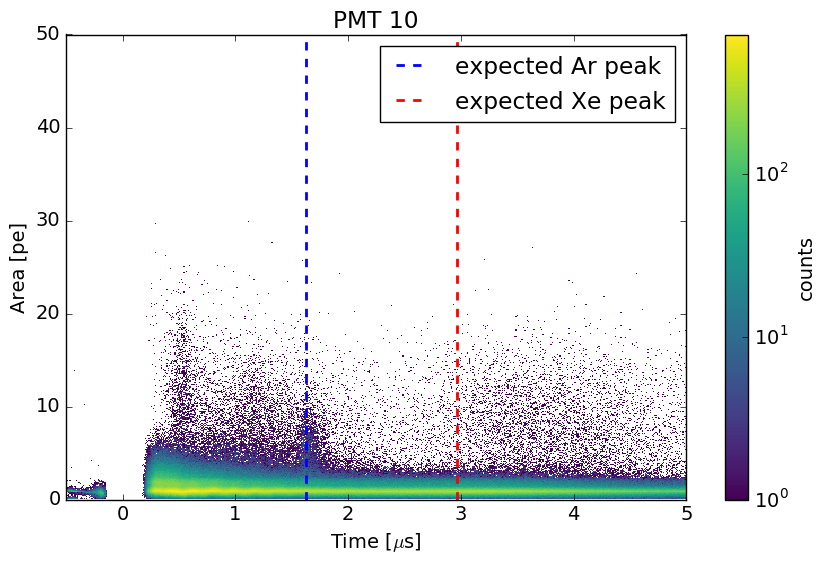

10


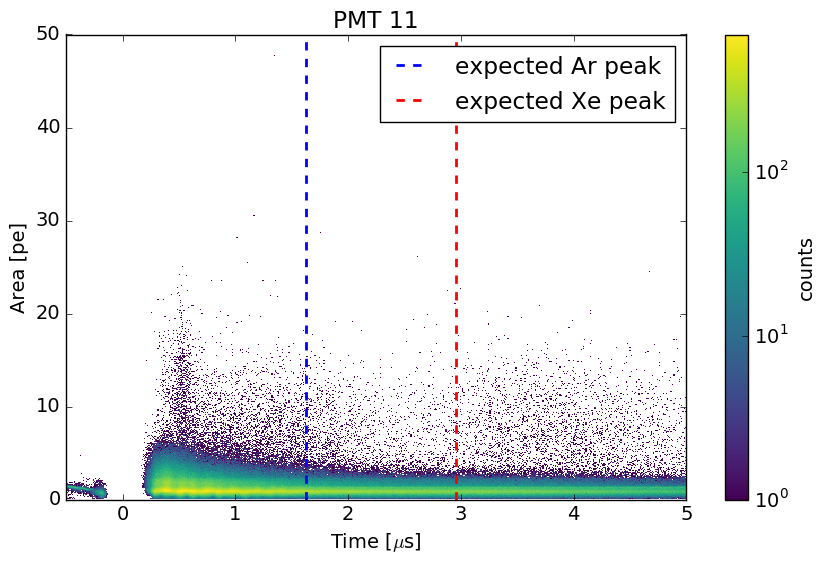

11


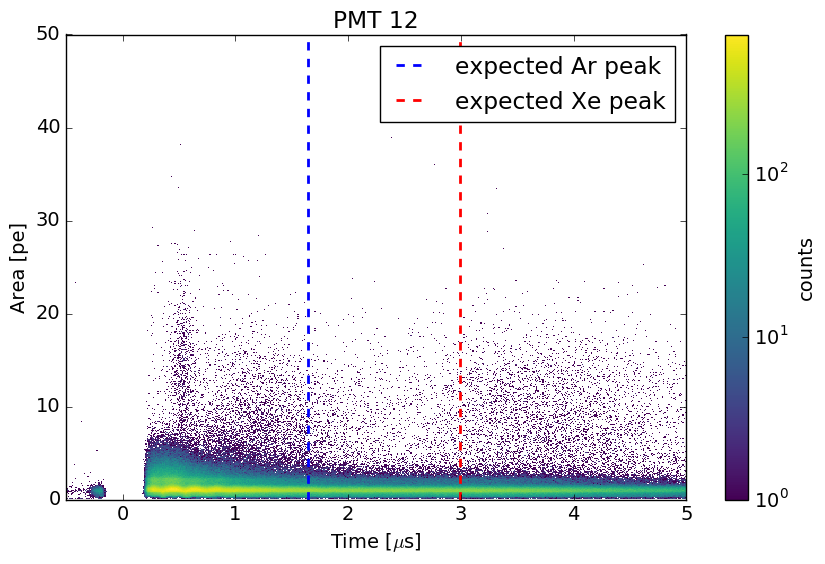

12


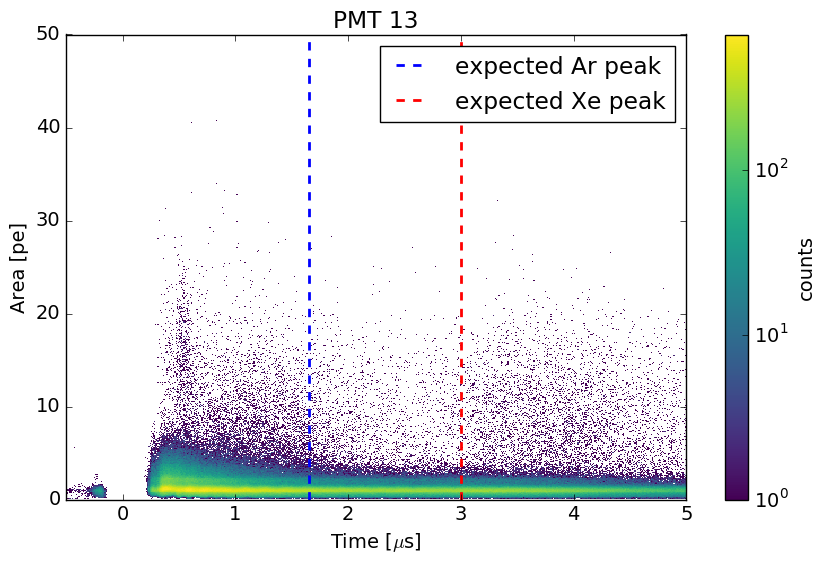

13


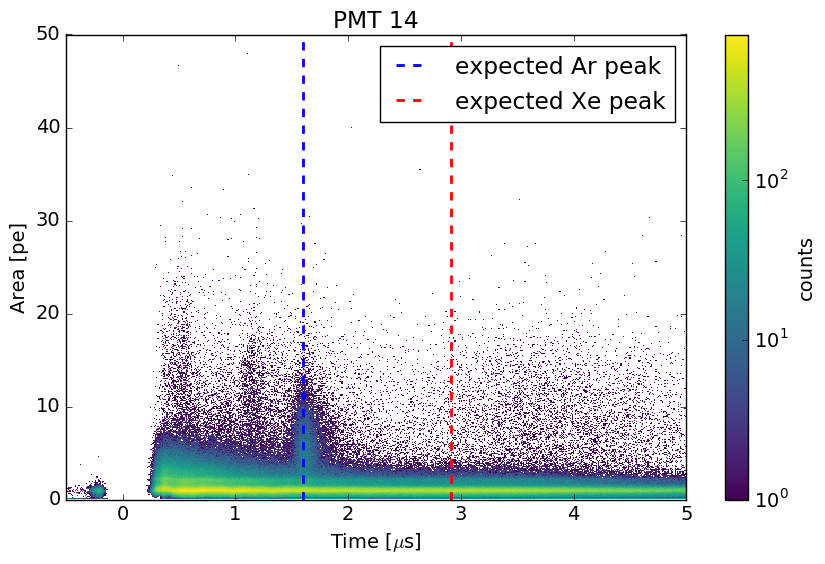

In [19]:
for pmt in range(1,15):
    if type(DF_all[pmt-1]) == int :
        continue
    AP_data = DF_all[pmt-1]
    print(pmt-1)
    plot(AP_data, pmt , arr[pmt-1],day)

In [20]:
##############      SKIP TO LAST CELL IF YOU ONLY WANT THE COUNTS    ################

In [21]:
def fit_exp(x, N, a, c1, c2):
    return N*np.exp(-a*x + c1) + c2



def XeAPratio(data_frame, valHV5e6):
    Nevents = 250000
    DF1= data_frame[(data_frame['time']<0.1)&(data_frame['time']>-0.1)]
    mean_illumination = np.mean(DF1.area)
    sigma_illum=np.sqrt(np.var(DF1.area))
    DF2=data_frame[(data_frame['time']<estimateXePosition(valHV5e6)+0.15)&(data_frame['time']>estimateXePosition(valHV5e6)-0.15)]
    mean_Xe = np.mean(DF2.area)
    DF3=data_frame[(data_frame['time']<estimateXePosition(valHV5e6)+0.45)&(data_frame['time']>estimateXePosition(valHV5e6)+0.15)]
    mean_bkg= np.mean(DF3.area)
    N_Xe = len(DF2.area) 
    sigma_N_Xe = np.sqrt(N_Xe)
    error = np.sqrt((sigma_N_Xe/(mean_illumination*Nevents))**2+(N_Xe*sigma_illum/(Nevents*mean_illumination**2))**2)
    print("mean area Xe region = %f \n mean area bkg region = %f " %(mean_Xe, mean_bkg), sigma_N_Xe/(mean_illumination*Nevents)*100)
    return (N_Xe/(mean_illumination*Nevents)*100, error*100)
                                                                            
def plot1dhist(data_frame,pmt,func,valHV5e6,day):
    plt.figure(figsize=(10,6))
    data_frame1=data_frame[(data_frame['area']<50)]
    weights = np.ones_like(data_frame1['time'])/float(len(data_frame['time'])) # normalized to ALL events (above 2pe th.)
    h, bin_edges, _= plt.hist( data_frame1['time'], bins=500, range=((0, 5)), normed = False, weights = weights) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[(histDF['bin_centres']<1.3) | (histDF['bin_centres']>4)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    #res = curve_fit(func, bin_centers, h1, p0=[500,1, 1, 0])
    XePeak = estimateXePosition(valHV5e6)
    ArPeak = estimateArPosition(valHV5e6)
    plt.axvline(ArPeak, color='b', linestyle='dashed', linewidth=2, label = 'expected Ar peak')
    plt.axvline(XePeak, color='red', linestyle='dashed', linewidth=2, label = 'expected Xe peak')
    plt.axvline(XePeak+0.15, color ='black', linestyle='dashed', linewidth=0.5)
    plt.axvline(XePeak-0.15, color ='black', linestyle='dashed', linewidth=0.5)
    plt.legend(loc = 'upper right')
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('events/triggers')
    plt.title('PMT %d' % pmt)
    #plt.plot(bin_centres, func(bin_centres, *res[0]))
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_run6_%d.png' % (pmt,day), dpi=150, transparent = False)
    plt.show()
    plt.clf()
    Xe_AP, error = XeAPratio(data_frame,valHV5e6)
    #print('Xe ap rate = (%f +- %f)%%'  %(Xe_AP, error))
    """residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp-fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-100,200])
    #plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_expfit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()
    """
    return (Xe_AP, error)


In [22]:
type(DF_all[6])

pandas.core.frame.DataFrame

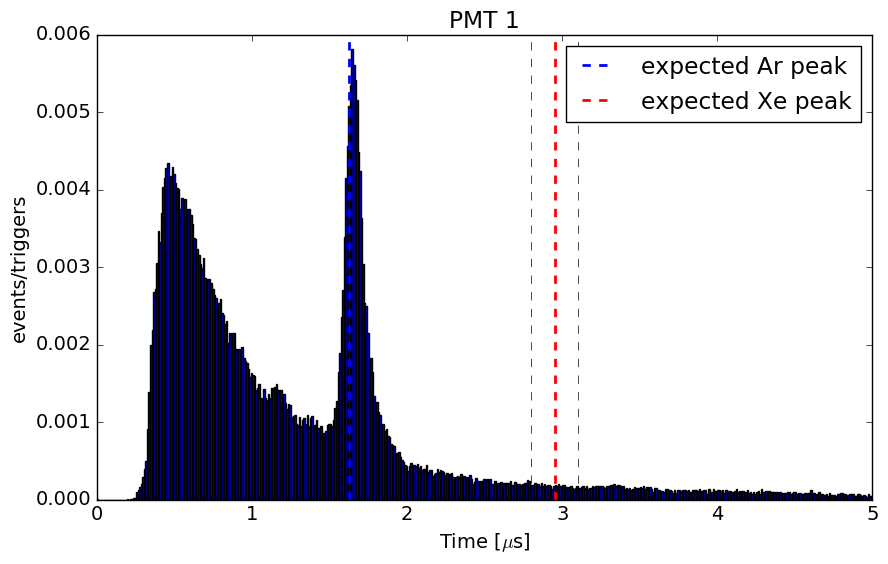

mean area Xe region = 4.419379 
 mean area bkg region = 5.014173  0.000104579998612
Xenon afterpulse upper limit < 0.000763 % (at 90% CL)


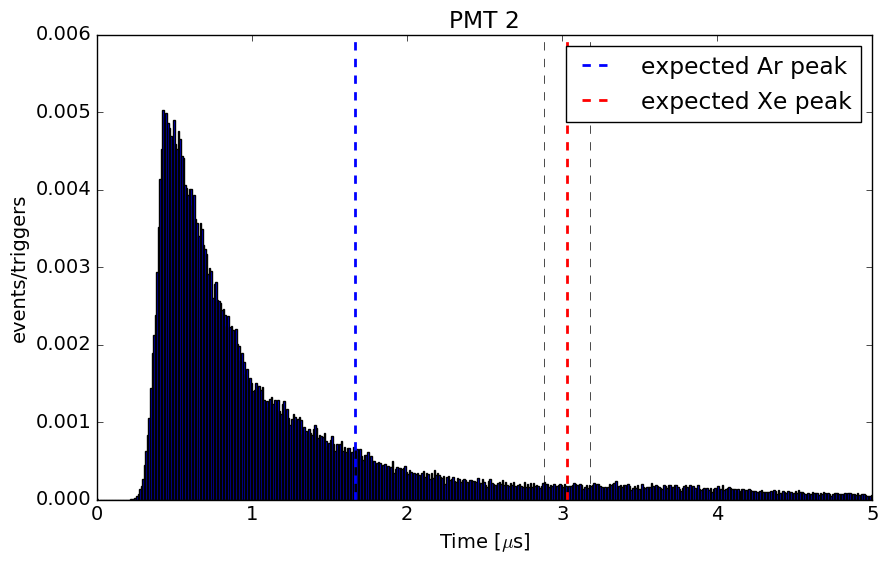

mean area Xe region = 6.584400 
 mean area bkg region = 5.717104  0.000118680777138
Xenon afterpulse upper limit < 0.000789 % (at 90% CL)


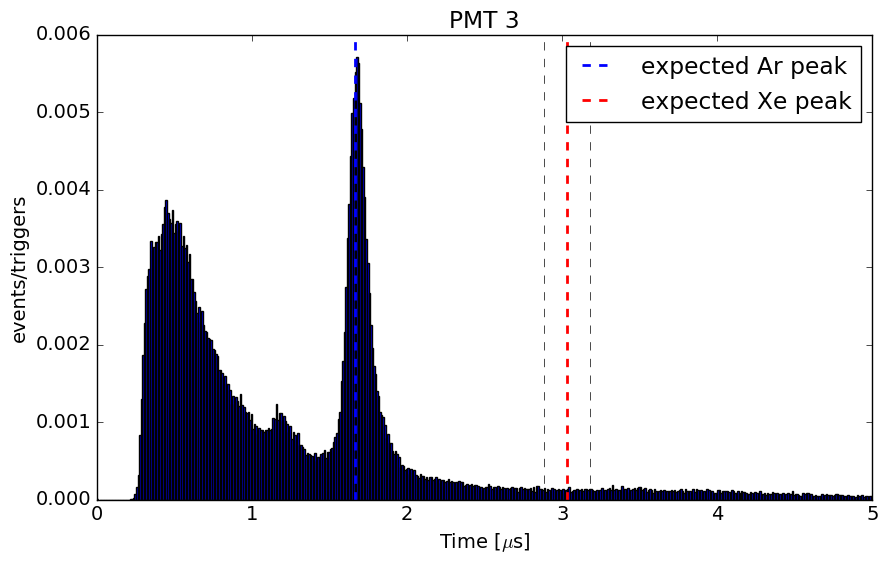

mean area Xe region = 7.501988 
 mean area bkg region = 4.775161  0.000102062314247
Xenon afterpulse upper limit < 0.000569 % (at 90% CL)


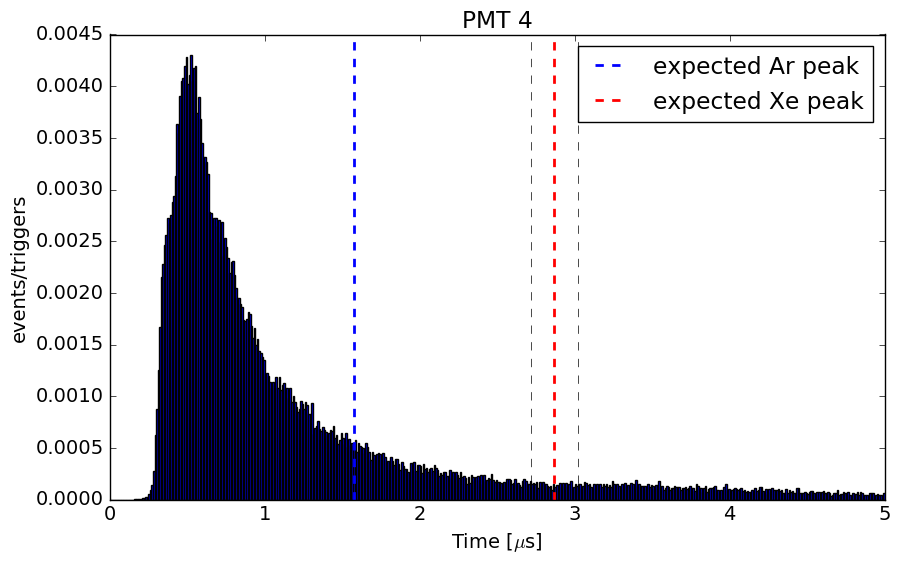

mean area Xe region = 7.845250 
 mean area bkg region = 4.752379  9.3868748394e-05
Xenon afterpulse upper limit < 0.000618 % (at 90% CL)


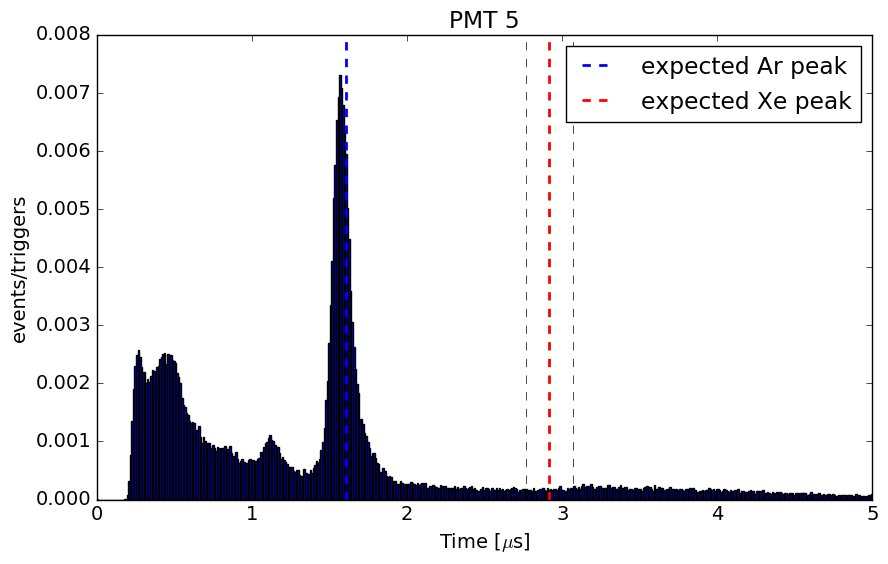

mean area Xe region = 5.241745 
 mean area bkg region = 7.263441  0.000118558953945
Xenon afterpulse upper limit < 0.000817 % (at 90% CL)


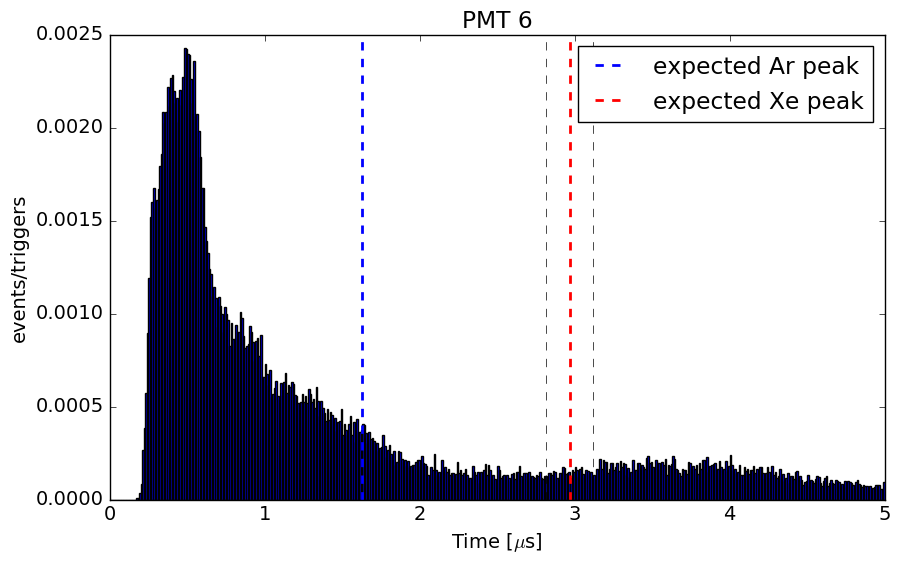

mean area Xe region = 4.935063 
 mean area bkg region = 4.715310  8.9501070198e-05
Xenon afterpulse upper limit < 0.000416 % (at 90% CL)


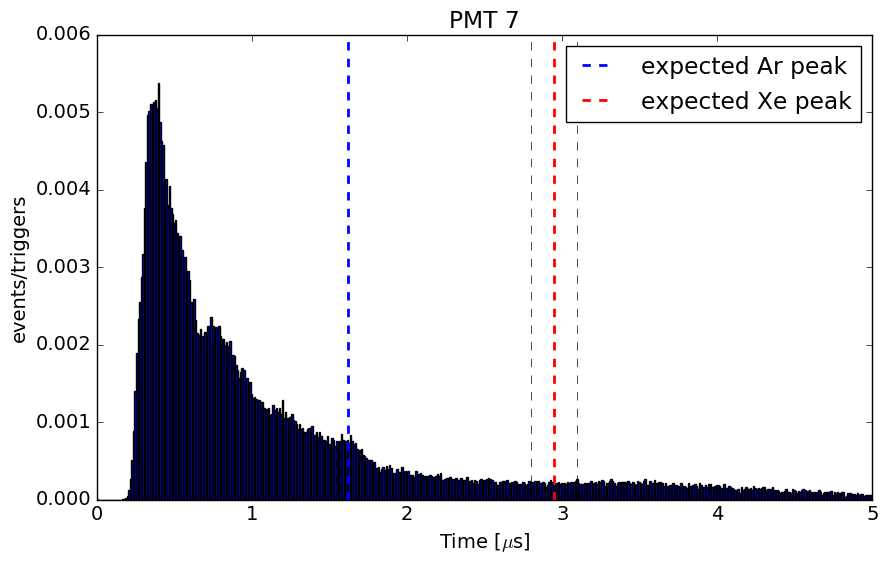

mean area Xe region = 5.778584 
 mean area bkg region = 5.625872  0.000120088101922
Xenon afterpulse upper limit < 0.000815 % (at 90% CL)


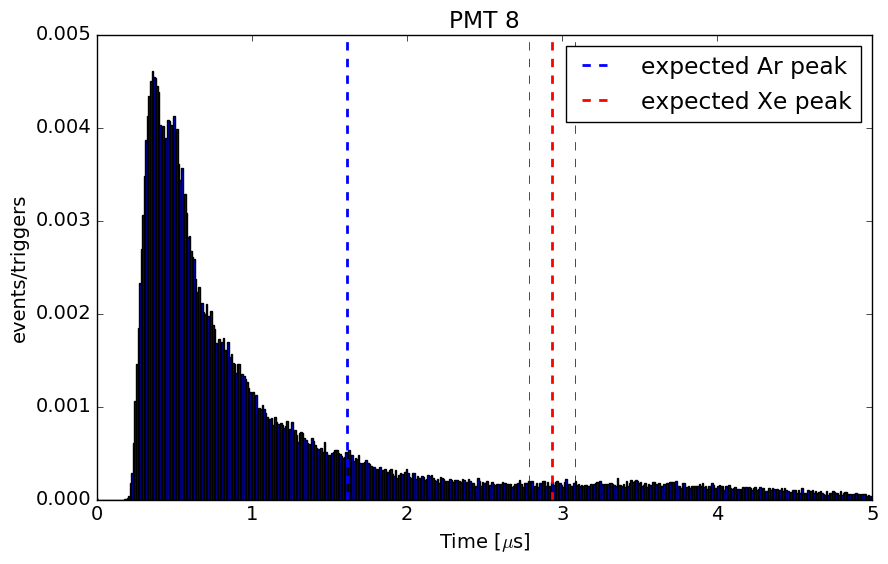

mean area Xe region = 4.612141 
 mean area bkg region = 5.566271  0.000111858217787
Xenon afterpulse upper limit < 0.000699 % (at 90% CL)


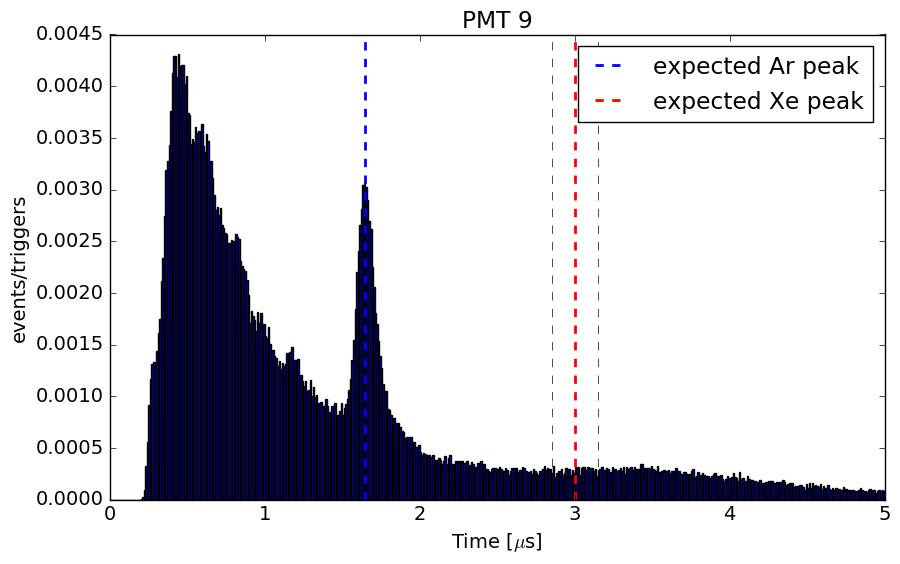

mean area Xe region = 4.779650 
 mean area bkg region = 5.276717  0.000145757131791
Xenon afterpulse upper limit < 0.001178 % (at 90% CL)


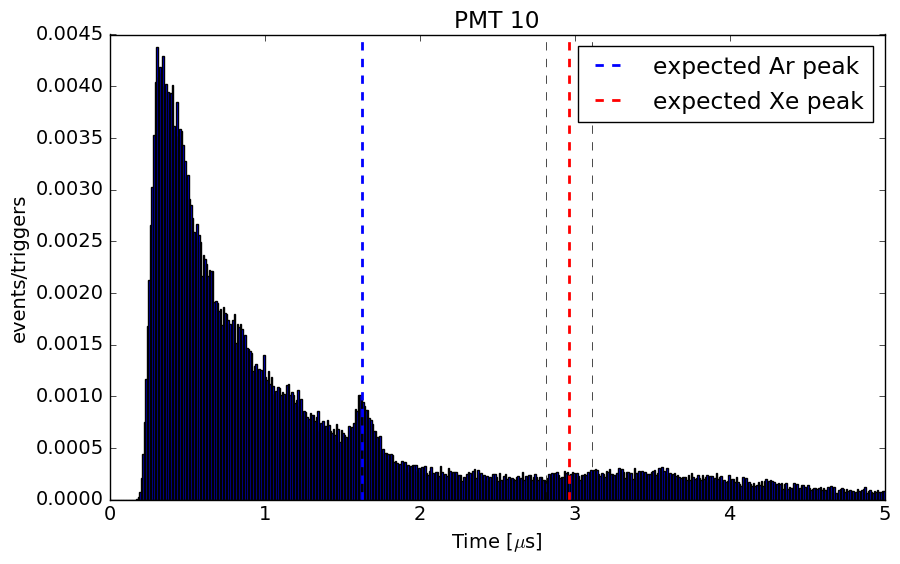

mean area Xe region = 4.853917 
 mean area bkg region = 5.295024  0.000113135103334
Xenon afterpulse upper limit < 0.000741 % (at 90% CL)


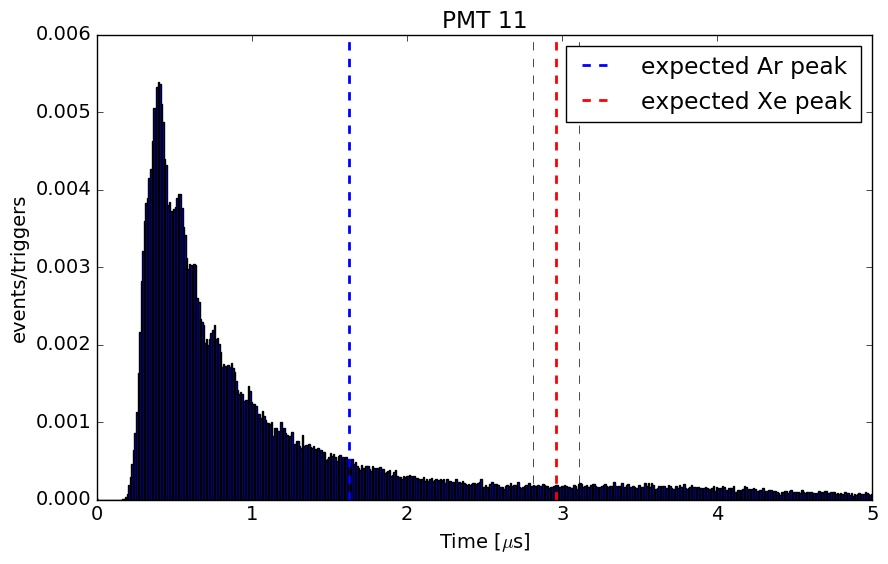

mean area Xe region = 3.365744 
 mean area bkg region = 4.610232  0.000101529841637
Xenon afterpulse upper limit < 0.000571 % (at 90% CL)


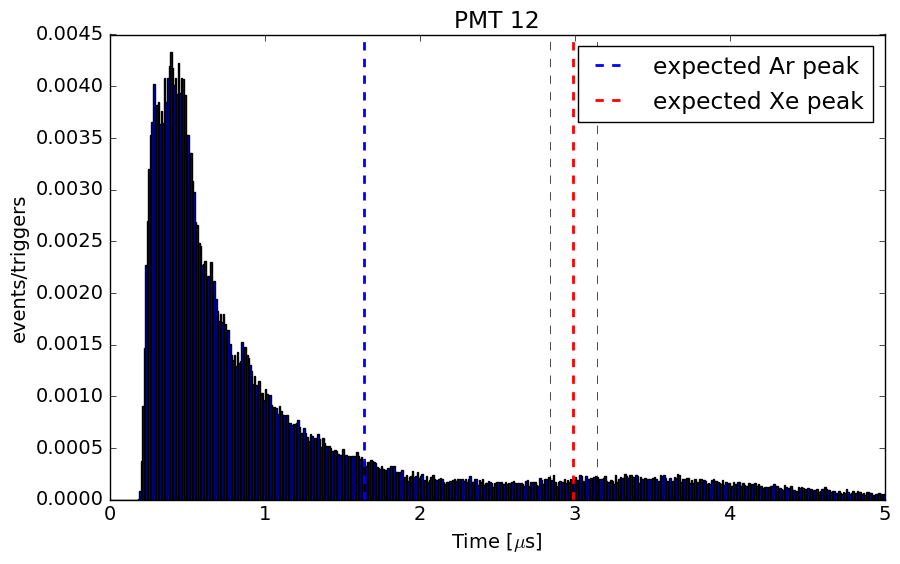

mean area Xe region = 5.971267 
 mean area bkg region = 6.441208  0.00011926391287
Xenon afterpulse upper limit < 0.000832 % (at 90% CL)


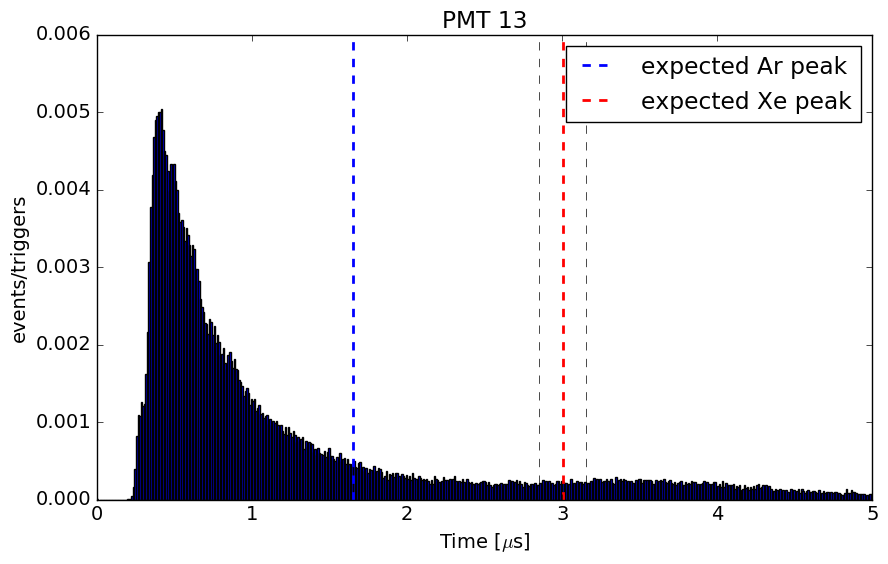

mean area Xe region = 4.308529 
 mean area bkg region = 5.509667  0.000113445243459
Xenon afterpulse upper limit < 0.000778 % (at 90% CL)


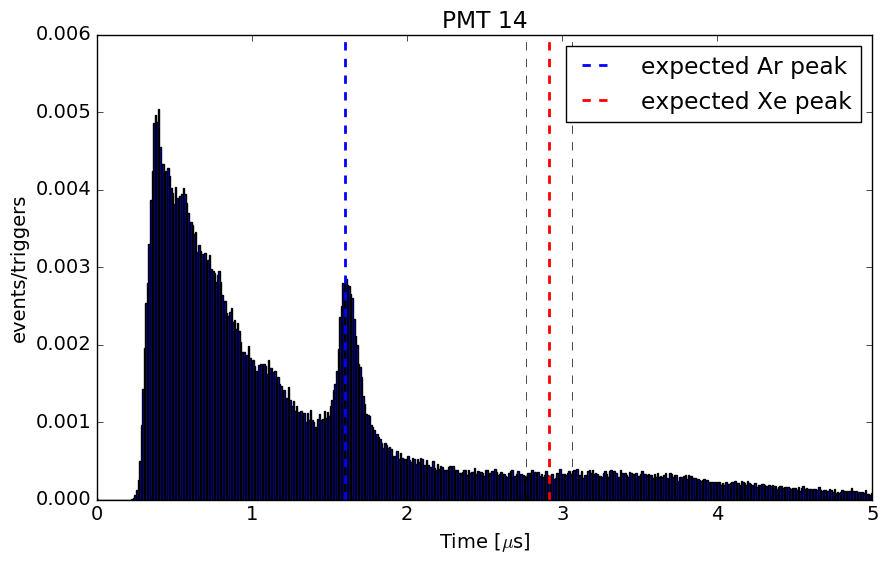

mean area Xe region = 4.981849 
 mean area bkg region = 3.960490  0.000141490492998
Xenon afterpulse upper limit < 0.001272 % (at 90% CL)


In [23]:
from pathlib import Path
f=open(path_CSV+"Run%d_%d_Xe_UL.dat" %(run,day),"w+")
f.write("#PMT, Xe AP UL\n")
for pmt in range(1,15):
    #if pmt==14:
     #   f.close()
    #    continue
    #print(file)
    #channel = int(file.split("_")[1].lstrip("wf"))
    #board = int(file.split("_")[2].lstrip("Board"))
    run = int(path.split("/")[5].lstrip("run"))
    day = int(path.split("/")[7].lstrip("ap"))
    #pmt = channel + 1 + board * 7
    #print(channel,board, pmt, run, day)
    #print (pmt)
    #if pmt!=7:
    #    continue
    if type(DF_all[pmt-1]) == int :
        continue
    AP_data = DF_all[pmt-1]
    #AP_data = AP_data[AP_data['entropy']<0.4]
    
    xe_AP_nf, error_nf = plot1dhist(AP_data[AP_data['area']>2.],pmt,fit_exp,arr[pmt-1],day)
    Xe_UL = 1.64*error_nf
    print("Xenon afterpulse upper limit < %f %% (at 90%% CL)" %Xe_UL)
    f.write("%d,%f\n" %(pmt,Xe_UL))
    if pmt==14:
        f.close()
    

# Fitting and Xenon AP rate calculation in LEAKY PMTs

In [47]:
Nevents = 250000

def XeAPrate(data_frame, Nevents, valHV5e6,func,x, *pars):
    DF1= data_frame[(data_frame['time']<0.1)&(data_frame['time']>-0.1)]
    mean_illumination = np.mean(DF1.area)
    sigma_illum=np.sqrt(np.var(DF1.area))
    Xe_peak=estimateXePosition(valHV5e6)
    DF2=data_frame[(data_frame['time']<(Xe_peak+0.15))&((data_frame['time']>(Xe_peak-0.15)))]
    func1 = lambda x: func(x, *pars)
    bkg_fit=0.
    for i in range (0,31):    
        bkg_fit+=func1(i/30*0.30+Xe_peak-0.15)
    print(bkg_fit)
    #bkg_fit,_=sp_int.quad(func1,Xe_peak-0.15,Xe_peak+0.15)
    N_Xe = len(DF2.area)-bkg_fit
    sigma_N_Xe = np.sqrt(len(DF2.area))
    error = np.sqrt((sigma_N_Xe/(mean_illumination*Nevents))**2+(len(DF2.area)*sigma_illum/(Nevents*mean_illumination**2))**2+(bkg_fit)*(1/(mean_illumination*Nevents))**2)
    #print(error*100, sigma_N_Xe/(mean_illumination*Nevents)*100, N_Xe*sigma_illum/(Nevents*mean_illumination**2)*100,100/(mean_illumination*Nevents)* np.sqrt(bkg_fit) )
    return (N_Xe/(mean_illumination*Nevents)*100, error*100)

In [1]:
def fit_exp_gaus(x, Ne, a, c1, c2, Ng, sigma, mu):
    return Ne*np.exp(-a*x + c1) + c2 + Ng*sps.norm.pdf(x, loc=mu, scale = sigma)

def plot1dhist_fit(data_frame,pmt,func,valHV5e6):
    plt.figure(figsize=(10,6))
    #data_frame1=data_frame[(data_frame['area']<50)]
    #weights = np.ones_like(data_frame1['time'])/float(len(data_frame['time'])) # normalized to ALL events (above 2pe th.)
    h, bin_edges, _= plt.hist( data_frame['time'], bins=450, range=((0.5, 5)), normed = False) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[((histDF['bin_centres']>2.3)&(histDF['bin_centres']<2.55))|
                  (histDF['bin_centres']>3.5)]#&(histDF['bin_centres']<3.35))|(histDF['bin_centres']>4.55)] #define the range of fitting
    XePeak = estimateXePosition(valHV5e6)
    ArPeak = estimateArPosition(valHV5e6)
    plt.axvline(ArPeak, color='b', linestyle='dashed', linewidth=2, label = 'expected Ar peak')
    plt.axvline(XePeak, color='red', linestyle='dashed', linewidth=2, label = 'expected Xe peak')
    plt.axvline(XePeak+0.15, color ='black', linestyle='dashed', linewidth=0.5)
    plt.axvline(XePeak-0.15, color ='black', linestyle='dashed', linewidth=0.5)
    plt.legend(loc = 'upper right')
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('events')
    plt.title('PMT %d' % pmt)
    #if pmt==11:
    #    histDF=histDF[(histDF['bin_centres']>3.1)] #define the range of fitting
    #if pmt == 11 or pmt ==14:
    #    return
    
    h1 = np.array(histDF.height)
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[400,1, 1, 0,100,3,3.5], maxfev = 150000)
    
    
    plt.plot(bin_centres[150:], func(bin_centres, *res[0])[150:])
    #plt.savefig(path+'AP_fig/'+'ap_pmt%d_profile_run5_gas_fit_gaus+exp.png' % pmt, dpi=150, transparent = False)
    plt.show()
    plt.clf()
    Xe_AP, error = XeAPrate(data_frame,Nevents,valHV5e6,func,bin_centres[150:],*res[0])
    Xe_AP_nf, error_nf = XeAPratio(data_frame,valHV5e6)
    print ("Xenon AP rate = %f +-%f %%" %(Xe_AP, error))
    print("Xenon AP upper limit = %f%% at 90%%CL"%(Xe_AP+1.64*error))
    #print(error_nf)
    return (Xe_AP, error, Xe_AP_nf, error_nf)

In [2]:
from pathlib import Path
for pmt in range(1,15):
    if type(DF_all[pmt-1]) == int :
        continue
    if pmt ==14:
        continue
    AP_data = DF_all[pmt-1]
    #AP_data = AP_data[AP_data['entropy']<0.4]
    xe_AP_fit, error_fit, xe_AP_nf, err_nf = plot1dhist_fit(AP_data[AP_data['area']>2.],pmt,fit_exp_gaus,arr[pmt-1])
    
    sw = False  #TRUE FOR calculating and saving the values!
    if sw == True:
        my_file = Path(path_CSV+"Run_%d_PMT_%d_APrate.csv" %(run,pmt))
        if my_file.is_file():
                data=pd.read_csv(my_file,sep=',', index_col='index')
                
                if data['Day'][data.index[-1]]==day:
                    data.loc[len(data)-1]=[day,xe_AP_fit,xe_AP_nf,error_fit,err_nf]
                    data.to_csv(path_CSV+"Run_%d_PMT_%d_APrate.csv" %(run,pmt),sep=',')
                else:   
                    print(data)
                    data.loc[len(data)]=[day,xe_AP_fit,xe_AP_nf,error_fit,err_nf]
                    #nw_data =pd.DataFrame([day,xe_AP_fit,xe_AP_nf,error_fit,err_nf], 
                    #                     columns = ['Day','Xe_AP_fit','Xe_AP_nf','error_f','error_nf'])
                    #data.append(nw_data)
                    data.to_csv(path_CSV+"Run_%d_PMT_%d_APrate.csv" %(run,pmt),sep=',')
        else:
            date = [day]
            unfitted= [xe_AP_nf]
            err_un = [err_nf]
            fitted = [xe_AP_fit]
            err_fit = [error_fit]
            
            dicti={'Day': np.array(date),
                   'Xe_AP_nf':np.array(unfitted),
                   'error_nf':np.array(err_un),
                   'Xe_AP_fit':np.array(fitted),
                   'error_f':np.array(err_fit)}
            data=pd.DataFrame(dicti)
            data.index.name='index'
            #print(unfitted,err_un)
            #myfile = open(path_CSV+"Run_%d_PMT_%d_APrate.csv" %(run,pmt), 'w')
            data.to_csv(path_CSV+"Run_%d_PMT_%d_APrate.csv" %(run,pmt),sep=',')
            
            
"""   else:   #WROOOOONG!
        if ul>0:
            ul=bkg_fit+1.64*error_fit
        else:
            ul=1.64*error_fit
        print('Xe_AP < %f %%' %ul)""" 
            

NameError: name 'DF_all' is not defined

# UPPER LIMIT for good PMTs

In [160]:
os.listdir(path)

['processed_wf2_Board1_AP_LED_2.205V.root',
 'processed_wf1_Board1_AP_LED_2.25V.root',
 'processed_wf4_Board1_AP_LED_2.315V.root',
 'processed_wf6_Board0_AP_LED_2.12V.root',
 'processed_wf3_Board0_AP_LED_2.3V.root',
 'processed_wf0_Board1_AP_LED_2.205V.root',
 'processed_wf3_Board1_AP_LED_2.315V.root',
 'processed_wf5_Board1_AP_LED_2.12V.root',
 'AP_figs',
 'counts',
 'processed_wf5_Board0_AP_LED_2.09V.root',
 'processed_wf1_Board0_AP_LED_2.26V.root',
 'processed_wf6_Board1_AP_LED_2.12V.root',
 'processed_wf0_Board0_AP_LED_2.205V.root',
 'processed_wf2_Board0_AP_LED_2.26V.root',
 'processed_wf4_Board0_AP_LED_2.3V.root']

In [245]:
all_files = os.listdir(path)
outfile = open(path+'counts/'+'counts.txt', 'w')
outfile.write("######################\n")
outfile.write("The numbers are as folows:\n")
outfile.write("PMT#\n")
outfile.write("Counts in left sideband (2.31 to 2.67)#\n")
outfile.write("Counts in left sideband (2.4 to 2.67)#\n")
outfile.write("Counts in left sideband (2.49 to 2.67)#\n")
outfile.write("Counts in left sideband (2.58 to 2.67)#\n")
outfile.write("Counts in right sideband (3.03 to 3.12)#\n")
outfile.write("Counts in right sideband (3.03 to 3.21)#\n")
outfile.write("Counts in right sideband (3.03 to 3.3)#\n")
outfile.write("Counts in left sideband (3.03 to 3.39)#\n")
outfile.write("Counts in signalband (2.67 to 3.03)#\n")
outfile.write("Threshold\n")
outfile.write("######################\n")
for file in os.listdir(path):
    if 'counts' in file:
        continue
    if 'AP_figs' in file:
        continue
    
    threshold=2
    filename = file
    channel = int(file.split("_")[1].lstrip("wf"))
    board = int(file.split("_")[2].lstrip("Board"))
    pmt = channel + 1 + board * 7
    print(path + filename)
    DataFrame = process_ap_file(path + filename)
    
    """
    def apply_selection(row):
        global counter_sig
        global counter_up1
        global counter_up2
        global counter_up3
        global counter_low1
        global counter_low2
        global counter_low3
        pos_j = row.time/100. -2.
        if not row.area > threshold:
            return
        if pos_j<2.67 and pos_j>2.4:
            counter_low1 +=1
        if pos_j<2.67 and pos_j>2.49:
            counter_low2 +=1
        if pos_j<2.67 and pos_j>2.58:
            counter_low3 +=1
        if pos_j<3.12 and pos_j>3.03:
            counter_up1 +=1
        if pos_j<3.21 and pos_j>3.03:
            counter_up2 +=1
        if pos_j<3.3 and pos_j>3.03:
            counter_up3 +=1
        if pos_j<3.03 and pos_j>2.67:
            counter_sig +=1
        return
    
    DataFrame.apply(apply_selection, axis=1)
    """
    
    above_threshold = DataFrame[DataFrame.area > threshold]
    
    
    counter_low1 = ((above_threshold.time/100.-2. > 2.4) & (above_threshold.time/100.-2. < 2.67)).sum()
    counter_low2 = ((above_threshold.time/100.-2. > 2.49) & (above_threshold.time/100.-2. < 2.67)).sum()
    counter_low3 = ((above_threshold.time/100.-2. > 2.58) & (above_threshold.time/100.-2. < 2.67)).sum()
    counter_low4 = ((above_threshold.time/100.-2. > 2.31) & (above_threshold.time/100.-2. < 2.67)).sum()
    
    counter_up1 = ((above_threshold.time/100.-2. > 3.03) & (above_threshold.time/100.-2. < 3.12)).sum()
    counter_up2 = ((above_threshold.time/100.-2. > 3.03) & (above_threshold.time/100.-2. < 3.21)).sum()
    counter_up3 = ((above_threshold.time/100.-2. > 3.03) & (above_threshold.time/100.-2. < 3.3)).sum()
    counter_up4 = ((above_threshold.time/100.-2. > 3.03) & (above_threshold.time/100.-2. < 3.39)).sum()
    
    counter_sig = ((above_threshold.time/100.-2. > 2.67) & (above_threshold.time/100.-2. < 3.03)).sum()

    
    """
    for j in range(len(DataFrame['time'])):
        pos_j=DataFrame.time[j]/100.-2.
        area_j=DataFrame.area[j]
        #print(pos_j,area_j)
        if pos_j<2.67 and pos_j>2.4 and area_j>threshold:
            counter_low1 +=1
        if pos_j<2.67 and pos_j>2.49 and area_j>threshold:
            counter_low2 +=1
        if pos_j<2.67 and pos_j>2.58 and area_j>threshold:
            counter_low3 +=1
        if pos_j<3.12 and pos_j>3.03 and area_j>threshold:
            counter_up1 +=1
        if pos_j<3.21 and pos_j>3.03 and area_j>threshold:
            counter_up2 +=1
        if pos_j<3.3 and pos_j>3.03 and area_j>threshold:
            counter_up3 +=1
        if pos_j<3.03 and pos_j>2.67 and area_j>threshold:
            counter_sig +=1
    """
    #plot(DataFrame, pmt)
    outfile.write("%d %d %d %d %d %d %d %d %d %d %d\n" % (pmt,counter_low4,counter_low1,counter_low2,counter_low3,counter_up1,counter_up2,counter_up3,counter_up4,counter_sig,threshold))
outfile.close()



2183it [00:00, 21825.70it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf2_Board1_AP_LED_2.205V.root


250000it [00:04, 52900.24it/s]
3634it [00:00, 36325.23it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf1_Board1_AP_LED_2.25V.root


250000it [00:05, 49465.81it/s]
3507it [00:00, 35063.01it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf4_Board1_AP_LED_2.315V.root


250000it [00:04, 50172.18it/s]
3298it [00:00, 32973.82it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf6_Board0_AP_LED_2.12V.root


250000it [00:04, 52597.04it/s]
3952it [00:00, 39350.23it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf3_Board0_AP_LED_2.3V.root


250000it [00:05, 47684.35it/s]
3469it [00:00, 34678.95it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf0_Board1_AP_LED_2.205V.root


250000it [00:04, 50476.57it/s]
3063it [00:00, 30621.41it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf3_Board1_AP_LED_2.315V.root


250000it [00:05, 49697.47it/s]
3165it [00:00, 31417.15it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf5_Board1_AP_LED_2.12V.root


250000it [00:04, 52382.30it/s]
3645it [00:00, 36272.83it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf5_Board0_AP_LED_2.09V.root


250000it [00:04, 54624.20it/s]
3260it [00:00, 32561.22it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf1_Board0_AP_LED_2.26V.root


250000it [00:04, 50620.72it/s]
4222it [00:00, 42181.92it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf6_Board1_AP_LED_2.12V.root


250000it [00:04, 53907.50it/s]
3462it [00:00, 34607.00it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf0_Board0_AP_LED_2.205V.root


250000it [00:04, 54296.31it/s]
3699it [00:00, 36980.60it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf2_Board0_AP_LED_2.26V.root


250000it [00:04, 50647.01it/s]
3059it [00:00, 30452.52it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf4_Board0_AP_LED_2.3V.root


250000it [00:05, 49520.93it/s]
